In [1]:

# import sys
# !{sys.executable} -m pip install plotly
# !{sys.executable} -m pip install keras

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# predefine color pallette alias
cnf = 'grey' # confirmed
dth = 'red' # death
rec = 'lightgreen' # recovered
act = 'orange' # active


## Train / Test Data

In [3]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

train_df.Country_Region.unique()

country = 'Korea, South'
df = train_df[train_df.Date > "2020-03-01"].groupby(['Country_Region', 'Date']).agg({'Fatalities': "sum"}).reset_index()
US_fatalities = df[df.Country_Region == country].Fatalities.cumsum()
Dates = df[df.Country_Region == country]['Date']

## Lockdown dates

In [4]:
lockdown = pd.read_csv("countryLockdowndates.csv")

lockdown.columns = ['Country_Region', 'Province_State', 'Date_lockdown', 'Type', 'Reference']

lowckdown_df = train_df.merge(lockdown, on=['Country_Region', 'Province_State'], how='left')

## Measures

In [5]:
measures = pd.read_csv("acaps-covid-19-government-measures-dataset.csv")

countries = measures.country.unique().tolist()

df_countries = train_df.Country_Region.tolist()

measures.columns = ['id', 'Country_Region', 'iso', 'admin_level_name', 'pcode', 'region',
       'category', 'measure', 'targeted_pop_group', 'comments',
       'measures_date_implemented', 'source', 'source_type', 'link', 'entry_date',
       'alternative_source']

measures = measures[[
    'id', 'Country_Region', 'category', 'measure', 'targeted_pop_group', 'comments', 'measures_date_implemented'
    ]]

measures["Country_Region"].replace({
    "United States of America": "US",
    "Russia": "Russian Federation",
    "Viet Nam": "Vietnam",
    "Korea Republic of": "Korea, South",
    "Czech Republic":"Korea, South"
    }, inplace=True)

measures['category'] = measures.category.str.lower()

measures['measure'] =  measures.measure.str.lower()

measures['measures_date_implemented'] = pd.to_datetime(measures["measures_date_implemented"], errors='coerce')

measures_country = measures.groupby(['Country_Region', 'measure']).agg({'measures_date_implemented': 'min'}).reset_index()



In [6]:

pivot_measures = pd.pivot_table(measures_country, values='measures_date_implemented', index=['Country_Region'],
                    columns=['measure'], aggfunc='min')
pivot_measures = pivot_measures.reset_index()



In [7]:
lowckdown_df.Date = pd.to_datetime(lowckdown_df.Date)
lockdown_measure_df = lowckdown_df.merge(
    pivot_measures, left_on=['Country_Region'], right_on=['Country_Region'], how='left')



In [8]:
for column in pivot_measures.columns.tolist():
    if column in ['Country_Region', 'measures_date_implemented']:
        continue
    lockdown_measure_df.loc[lockdown_measure_df['Date'] >= pd.to_datetime(lockdown_measure_df[column]), column+'_flag'] = 1
    lockdown_measure_df.drop(columns=[column], inplace=True)



In [9]:
lockdown_measure_df.fillna(0.0, inplace=True)

In [10]:
location_global = pd.read_csv("time_series_covid19_confirmed_global.csv")[['Province/State', 'Country/Region', 'Lat', 'Long']
                                                                  ].rename(columns={
                    'Province/State': 'Province_State',
                    'Country/Region': 'Country_Region'
})

location_us = pd.read_csv("time_series_covid19_confirmed_US.csv")[['Province_State', 'Country_Region', 'Lat', 'Long_']
                                                                  ].rename(columns={
                    'Long_': 'Long'
})

location = location_global.append(location_us)


location = location[(location.Lat != 0) & (location.Long != 0)].drop_duplicates(
    ['Province_State', 'Country_Region'])

location


lockdown_geo = lockdown_measure_df.merge(
    location.fillna(0.0), on=['Country_Region', 'Province_State'], how='left')

In [11]:
lockdown_geo['Location'] = lockdown_geo['Province_State'].astype(str) + '_' + lockdown_geo['Country_Region'].astype(str)


In [12]:
from sklearn import preprocessing

types = lockdown_geo.dtypes
cat_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

print('Label encoding categorical columns:', cat_columns)
encoders = {}
Locations = []
for col in cat_columns:
    lbl = preprocessing.LabelEncoder()
    if col == 'Location':
        Locations += lockdown_geo[col].unique().tolist()
    lockdown_geo[col] = lbl.fit_transform(lockdown_geo[col].astype(str))
    encoders[col] = lbl

Label encoding categorical columns: ['Province_State', 'Country_Region', 'Date', 'Date_lockdown', 'Type', 'Reference', 'Location']


In [13]:
features_set = []
labels = []

In [14]:
from tqdm import *

for i in tqdm(range(7, 66)):

    for location in lockdown_geo.Location.unique().tolist():
        df = lockdown_geo[lockdown_geo.Location == location].reset_index()
    
        features_set.append(df.iloc[i-7:i, 3:].values)
        labels.append(df.iloc[i, :]['ConfirmedCases'])

100%|██████████| 59/59 [00:40<00:00,  1.45it/s]


In [15]:
test_features_set = []
test_labels = []

for i in range(66, 74):
    for location in lockdown_geo.Location.unique().tolist():#encoders['Location'].transform(['New York_US']).tolist():#l
#         print(location)
        df = lockdown_geo[lockdown_geo.Location == location].reset_index()
        test_features_set.append(df.iloc[i-7:i, 3:].values)
        test_labels.append(df.iloc[i, :]['ConfirmedCases'])
        

In [16]:
features_set, labels = pd.np.array(features_set), pd.np.array(labels)
test_features_set, test_labels = pd.np.array(test_features_set), pd.np.array(test_labels)


In [17]:
size = features_set.shape[0]

split = int(size*(9/10))
values = pd.np.nan_to_num(features_set)
n_train_time = 365*24
train = values[:split, :, :]
test = values[split:, :, :]
train_y = labels[:split]

test_y = labels[split:]

In [18]:
import keras.backend as K

def rmsle(pred,true):
    assert pred.shape[0]==true.shape[0]
    return K.sqrt(K.mean(K.square(K.log(pred+1) - K.log(true+1))))


Using TensorFlow backend.


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units=100,input_shape=(features_set.shape[1], features_set.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(train, train_y, epochs = 10, batch_size = 32, validation_data=(test, test_y))


Train on 16248 samples, validate on 1806 samples
Epoch 1/10
16248/16248 [==============================] - 3s 209us/step - loss: 11192218.4229 - val_loss: 48805648.6267
Epoch 2/10
16248/16248 [==============================] - 3s 182us/step - loss: 9637257.9644 - val_loss: 40608953.9134
Epoch 3/10
16248/16248 [==============================] - 3s 191us/step - loss: 8422478.1025 - val_loss: 36112262.6199
Epoch 4/10
16248/16248 [==============================] - 3s 188us/step - loss: 7484586.8059 - val_loss: 35912114.2135
Epoch 5/10
16248/16248 [==============================] - 3s 182us/step - loss: 7388374.1024 - val_loss: 29391090.2028
Epoch 6/10
16248/16248 [==============================] - 3s 167us/step - loss: 6763473.0844 - val_loss: 27636153.0960
Epoch 7/10
16248/16248 [==============================] - 3s 190us/step - loss: 6220049.2326 - val_loss: 28293944.3805
Epoch 8/10
16248/16248 [==============================] - 3s 202us/step - loss: 5733182.2530 - val_loss: 21734199.064

In [20]:
out = model.predict(test_features_set)

In [21]:
test_locations = test_features_set[:,6,-1].tolist()
test_dates = test_features_set[:,6,1].tolist()
locs = encoders['Location'].inverse_transform([int(i) for i in test_locations]).tolist()
# [loc for loc in locs if '_US' in loc]

dates = encoders['Date'].inverse_transform([int(i) for i in test_dates]).tolist()
# [loc for loc in locs if '_US' in loc]

Forecast = pd.DataFrame({'Forecasted_cases': out.reshape((len(test_dates),)).tolist(), 'location': locs, 'Date': dates, 'True_cases': test_labels.tolist()})

US_Forecast = Forecast[Forecast.location.astype(str).str.contains('_US')]



In [29]:
fig = go.Figure()
for location in ['0.0_Spain', 'Washington_US', 'Michigan_US']:#US_Forecast.location.unique().tolist():
    location_df = Forecast[Forecast.location == location]
#     country_df = lockdown_geo[lockdown_geo.Country_Region == country].groupby(['Date']).agg({'Fatalities': 'sum'}).reset_index()
    fig.add_trace(go.Scatter(x=location_df.Date, y=location_df.True_cases,
                        mode='lines+markers',
                        name=location+' - True Cases'))

    fig.add_trace(go.Scatter(x=location_df.Date, y=location_df.Forecasted_cases,
                        mode='lines+markers',
                        name=location+' - Forecasted Cases'))

    fig.update_layout(
        title={
            'text': "Cases over time"})

fig.show()
    
    

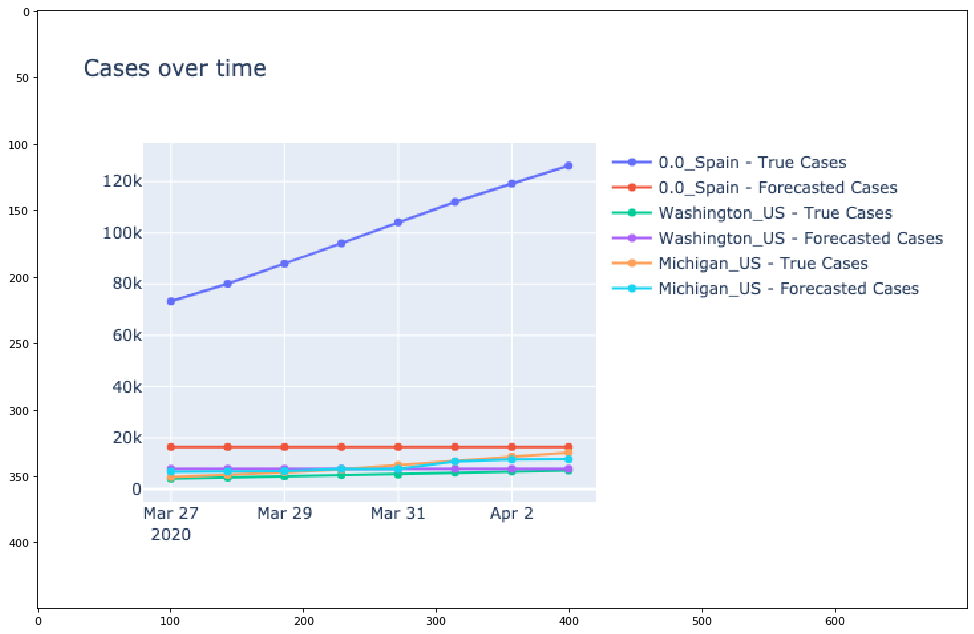

In [30]:
import matplotlib.image as mpimg
import cv2
from matplotlib.pyplot import figure

img=mpimg.imread('newplot.png')
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img)
